In [18]:
%reload_ext autoreload
%autoreload 2
    
from tqdm import tqdm

from pathlib import Path
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

import tasks
import models

from sklearn.decomposition import PCA
from rastermap import Rastermap

device = "cuda" if torch.cuda.is_available() else "cpu"

filepath = Path("~/Documents/Kempner/MCN2024/jobs/")
filepath = filepath.expanduser()

from analysis import load_perturbation, load_job, load_results, test_and_perturb, create_cdf_proportional_bins

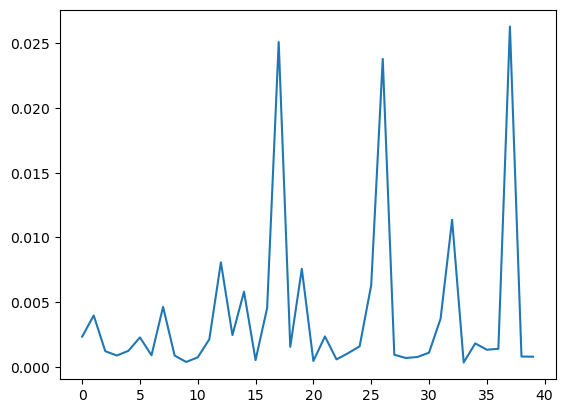

In [83]:
jobid = 44
train_loss, train_accuracy, train_evidence, train_fixation = load_results(jobid)

plt.close('all')
plt.plot(train_loss[:, -1])
plt.show()

In [84]:
# Load trained model and results

jobid = 44
model_index = 3
model, results, init_model = load_job(jobid, model_index=model_index, init=True)

args = results["args"]
task_params = results["task"]
train_loss = results["train_loss"]
train_accuracy = results["train_accuracy"]
train_evidence = results["train_evidence"]
train_fixation = results["train_fixation"]

task = tasks.ContextualGoNogo(
    args["input_dimensions"],
    args["end_sigma"],
    num_contexts=task_params["num_contexts"],
    stim_time=task_params["stim_time"],
    delay_time=args["end_delay"],
    decision_time=task_params["decision_time"],
    task_type=args["task_type"] if "task_type" in args else "embedded",
)
task.cursors = task_params["cursors"]

if args["network_type"] == "Gain":
    model_constructor = models.GainRNN
elif args["network_type"] == "Tau":
    model_constructor = models.TauRNN
elif args["network_type"] == "Full":
    model_constructor = models.FullRNN
elif args["network_type"] == "Intrinsic":
    model_constructor = models.IntrinsicRNN
else:
    raise ValueError("Unknown network type")


kwargs = dict(
    gainfun=args["gainfun"],
    taufun=args["taufun"],
    tauscale=args["tauscale"],
)
if args["network_type"] != "Full":
    kwargs["input_rank"] = args["input_rank"]
    kwargs["recurrent_rank"] = args["recurrent_rank"]

net = model_constructor(
    task.input_dimensionality(),
    args["num_neurons"],
    task.output_dimensionality(),
    **kwargs,
)

net.load_state_dict(model)

<All keys matched successfully>

In [85]:
X, target, params = task.generate_data(10000, sigma=0.1, source_floor=1.0)
output, hidden = net(X, return_hidden=True)
output = output.detach()

all_hidden = np.array(hidden.view(-1, hidden.size(2)).detach()).T
pca = PCA(n_components=4).fit(all_hidden.T)
isort = torch.tensor(np.argsort(pca.components_[0]))

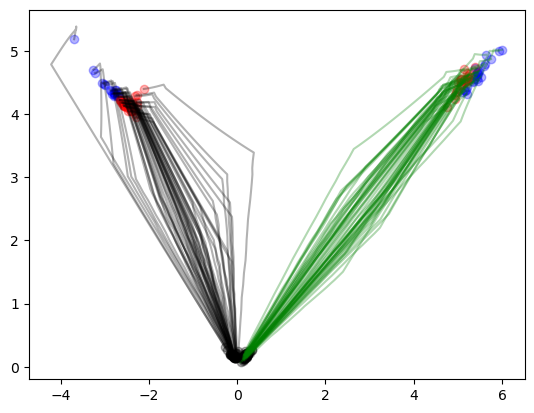

In [87]:
ibatch = 0

# task.decision_time = 
X, target, params = task.generate_data(100, source_floor=0.0, source_strength=0.5)
output, hidden = net(X, return_hidden=True)
output = output.detach()

context_idx = params["context_idx"]
labels = params["labels"]

pc_hidden = hidden.detach().numpy() @ pca.components_.T[:, [0, 1]]
fig = plt.figure()
plt.plot(pc_hidden[context_idx==0, :, 0].T, pc_hidden[context_idx==0, :, 1].T, c='k', alpha=0.3)
plt.plot(pc_hidden[context_idx==1, :, 0].T, pc_hidden[context_idx==1, :, 1].T, c='g', alpha=0.3)
plt.scatter(pc_hidden[:, 0, 0], pc_hidden[:, 0, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[labels==0, -1, 0], pc_hidden[labels==0, -1, 1], c='b')
plt.scatter(pc_hidden[labels==1, -1, 0], pc_hidden[labels==1, -1, 1], c='r')
plt.show()

In [32]:
pc_hidden[:, :, 0].shape

(1, 60)

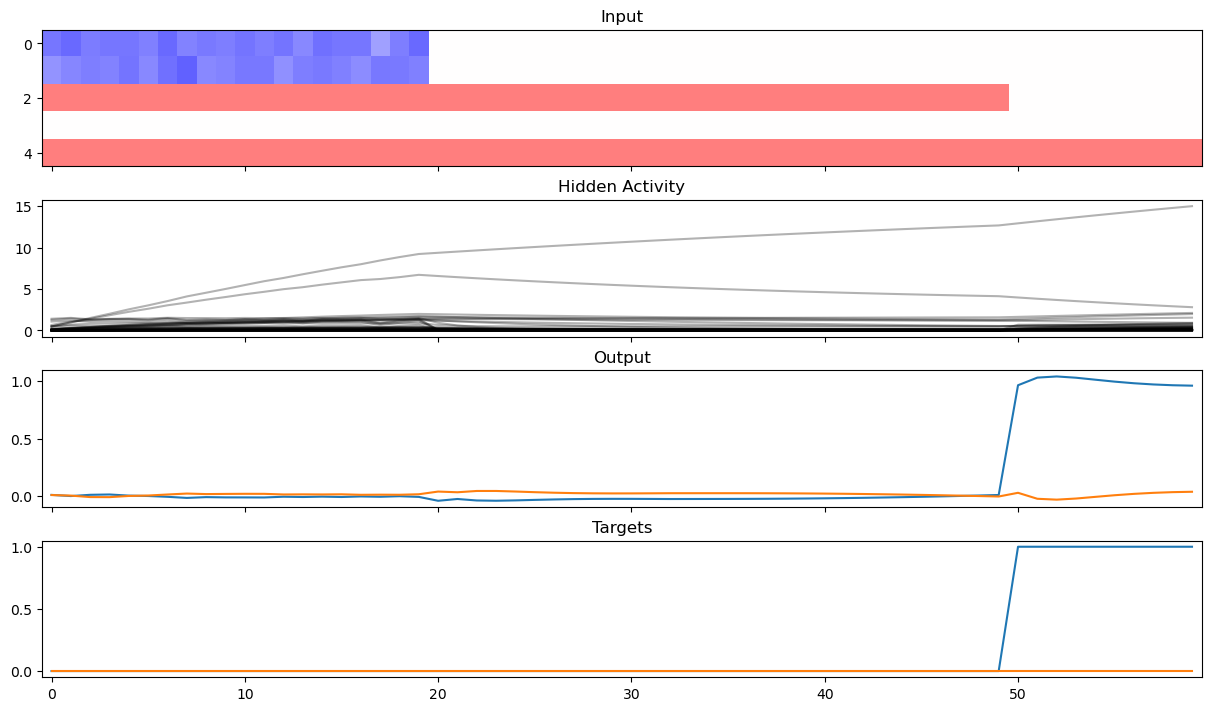

In [14]:
ibatch = 0

# task.decision_time = 
X, target, params = task.generate_data(1, source_floor=1.0, source_strength=0.5)
output, hidden = net(X, return_hidden=True)
output = output.detach()

fig, ax = plt.subplots(4, 1, figsize=(12, 7), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto", cmap="bwr", interpolation="none", vmin=-2, vmax=2)
ax[0].set_title("Input")
ax[1].plot(hidden[ibatch].detach().numpy()[:, isort], c='k', alpha=0.3)
# ax[1].imshow(hidden[ibatch].detach().numpy().T[isort], aspect="auto", interpolation="none", cmap='gray')
ax[1].set_title("Hidden Activity")
ax[2].plot(output[ibatch].detach().numpy(), label="Output")
ax[2].set_title("Output")
ax[3].plot(target[ibatch].detach().numpy(), label="Target")
ax[3].set_title("Targets")
plt.show()

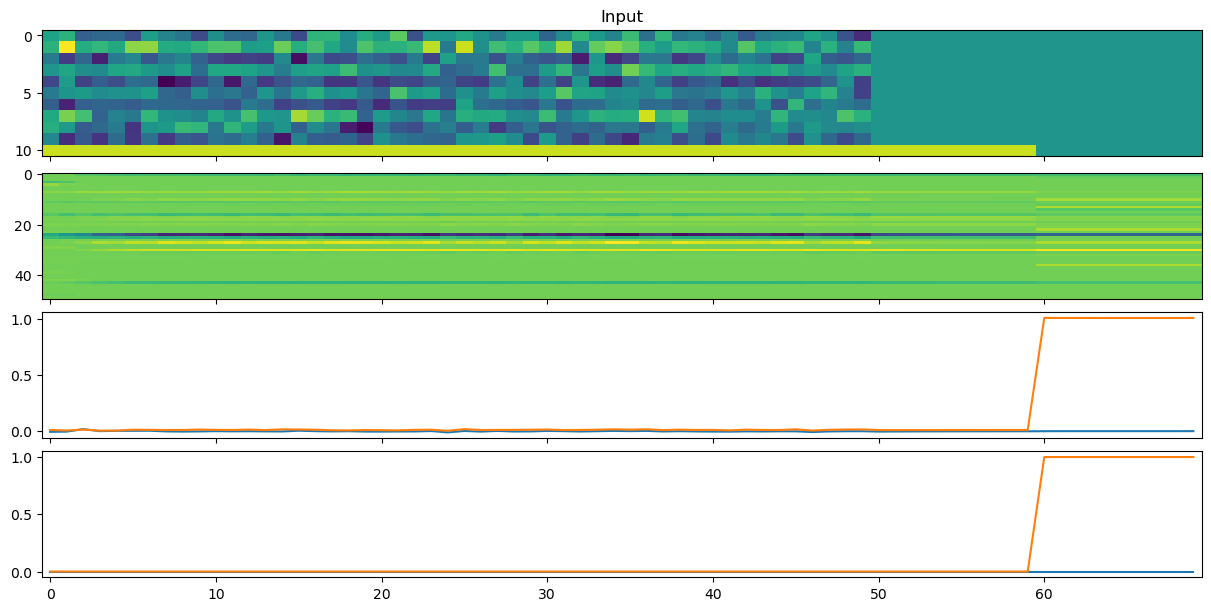

In [38]:
ibatch = 1

fig, ax = plt.subplots(4, 1, figsize=(12, 6), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[0].set_title("Input")
ax[1].imshow(hidden[ibatch].detach().numpy().T, aspect="auto", interpolation="none")
ax[2].plot(outputs[ibatch].detach().numpy(), label="Output")
ax[3].plot(target[ibatch].detach().numpy(), label="Target")
plt.show()

In [6]:
params["s_empirical"][:10]

tensor([-0.0974,  0.0866, -0.0177,  0.0962, -0.0976, -0.0620, -0.0904,  0.0902,
         0.0977, -0.0929])

Beta: Parameter containing:
tensor(0.8745, requires_grad=True) Alpha: Parameter containing:
tensor([0.6411, 0.8757], requires_grad=True)
torch.Size([11, 2]) torch.Size([2, 2])


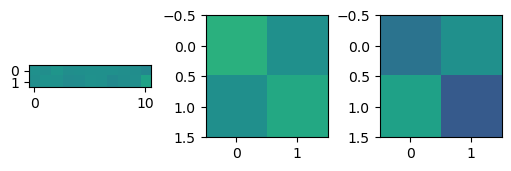

In [54]:
ipweight = net.input_weight.weight.detach().T
rcweight = net.recurrent_weight.weight.detach()
roweight = net.readout.weight.detach()
sd_score = roweight[0] - roweight[1]
isort = torch.argsort(sd_score)

print("Beta:", net.rnn.beta, "Alpha:", net.rnn.alpha)
print(ipweight.shape, rcweight.shape)

fig, ax = plt.subplots(1, 3, figsize=(5, 4), layout="constrained")
ax[0].imshow(ipweight.T[isort], vmin=-1, vmax=1)
ax[1].imshow(rcweight.T[isort][:, isort], vmin=-1, vmax=1)
ax[2].imshow(roweight.T[isort], vmin=-1, vmax=1)
plt.show()

In [44]:
ipweight.T

tensor([[-3.0019e-03,  8.0061e-03, -4.9607e-04, -7.6670e-03, -1.8169e-02,
          1.4057e-02, -5.0839e-03, -1.8974e-02,  3.1144e-03, -1.9640e-03,
          3.6878e-01],
        [ 9.8980e-04, -1.1440e-02, -8.7633e-04, -2.0143e-05, -2.5359e-03,
         -3.1783e-06, -3.8885e-02,  9.0732e-03, -1.1556e-05, -1.2034e-02,
          2.1957e-02]])

In [7]:
X, labels, params = task.generate_data(B)
outputs, spks, mems = net(X, start_integration=start_integration)
choice = torch.argmax(outputs, dim=1)

torch.cat((params["stimuli"][:10], labels[:10].unsqueeze(1), choice[:10].unsqueeze(1)), dim=1)

TypeError: ContextualGoNogo.generate_data() missing 1 required positional argument: 'T'

In [ ]:
ibatch = 8

print(X[ibatch].shape, spks[ibatch].shape, mems[ibatch].shape)

fig, ax = plt.subplots(3, 1, figsize=(9, 6), layout="constrained")
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[1].imshow(spks[ibatch][:, isort].detach().T, aspect="auto")
ax[2].imshow(mems[ibatch][:, isort].detach().T, aspect="auto")
plt.show()